In [8]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict
import numpy as np
from collections import Counter
import pickle

In [9]:
with open('cap.pck', 'rb') as f:
    cap = pickle.load(f)


In [10]:
len(cap)

100

In [11]:
with open('pref.pck', 'rb') as f:
    pref = pickle.load(f)

In [12]:
school_ids = list(cap.keys())

# Student IDs are in pref but not in cap
student_ids = [k for k in pref.keys() if k not in cap]

In [13]:
merged_cap = {}
merged_pref = {}

# Use a set to collect all base IDs
base_school_ids = set()

for sid in cap.keys():
    if sid.endswith("_REG") or sid.endswith("_PRI") :
        base_id = sid.rsplit("_", 1)[0]
        base_school_ids.add(base_id)
print(f"Number of base schools: {len(base_school_ids)}")

Number of base schools: 49


In [14]:
for base_id in base_school_ids:
    reg_id = base_id + "_REG"
    pri_id = base_id + "_PRI"
    pie_id = base_id + "_PIE"

    # Add capacities
    # Are capacities reg + priority? or is it contained? like priority as part of the regular capacities?
    cap_reg = cap.get(reg_id, 0)
    cap_pri = cap.get(pri_id, 0)
    cap_pie = cap.get(pie_id, 0)
    merged_cap[base_id] = cap_reg+cap_pri

    # Get priority lists from dicts sorted by rank (key)
    pri_list = [v for k, v in sorted(pref.get(pri_id, {}).items())]
    reg_list = [v for k, v in sorted(pref.get(reg_id, {}).items())]
    pie_list = [v for k, v in sorted(pref.get(pie_id, {}).items())]

    # Merge without duplicates
    seen = set()
    combined_priority = []
    for student in pri_list + reg_list:
        if student not in seen:
            seen.add(student)
            combined_priority.append(student)

    merged_pref[base_id] = combined_priority

In [15]:
# for sid in pref:
#     if sid not in cap:  # these are student IDs
#         merged_pref[sid] = pref[sid]

In [16]:
len(merged_pref)

49

In [17]:
print(f"Merged school count: {len(merged_cap)}")
sample_id = list(merged_cap.keys())[0]
print(f"Sample school ID: {sample_id}")
print(f"Capacity: {merged_cap[sample_id]}")
print(f"Top 5 priorities: {merged_pref[sample_id][:5]}")

Merged school count: 49
Sample school ID: 8434_401000000133
Capacity: 35
Top 5 priorities: ['5b8630f5093da070f20e8b0a', '5b8630ea093da070f20e56d4', '5b8630e2093da070f20e3619', '5b863101093da070f20ec2a5', '5b8631a4093da070f211b740']


In [18]:
all_cap = 0
for keys, _caps in merged_cap.items():
    all_cap += _caps
print(f"Total capacity: {all_cap}")

Total capacity: 1620


In [19]:
len(student_ids)

1395

In [20]:
def combine_school_preferences(preference_dict, student_ids):
    combined_preferences = {}

    for student_id in student_ids:
        if student_id not in preference_dict:
            continue

        original_prefs = preference_dict[student_id]
        seen = set()
        combined = []

        for rank in original_prefs:
            school_code = original_prefs[rank]
            school_base = school_code.rsplit('_', 1)[0]

            if school_base not in seen:
                seen.add(school_base)
                combined.append(school_base)


        combined_preferences[student_id] = combined

    return combined_preferences
student_pref = combine_school_preferences(pref, student_ids)


In [21]:
len(student_pref)

1395

In [22]:
school_pref = merged_pref

In [23]:
rank_student = {
    s: {sch: pos for pos, sch in enumerate(pref)}
    for s, pref in student_pref.items()
}
rank_school = {
    c: {stu: pos for pos, stu in enumerate(pref)}
    for c, pref in school_pref.items()
}

# all possible matches
S = list(student_pref.keys())
C = list(school_pref.keys())
E = [(s, c) for s in S for c in student_pref[s] if c in C]


student first vs school first (currently all student first)

In [24]:
Pref_count_student = set()
for s, pref in student_pref.items():
    Pref_count_student.add(len(pref))
Pref_count_student

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16}

In [25]:
m = gp.Model('StableMatching')

# set up decision variable
x = m.addVars(E, vtype=GRB.BINARY, name='x')

# Constraint: Each student matched to at most one school
m.addConstrs(x.sum(s, '*') <= 1   for s in S)

# Constraint: Stability
for s, c in E:
    better_schools = [c2 for c2 in student_pref[s]
                      if rank_student[s][c2] < rank_student[s][c]]
    better_students = [s2 for s2 in school_pref[c]
                       if s2 in rank_school[c] and
                          rank_school[c][s2] < rank_school[c][s]]
    m.addConstr(
        x[s, c] +
        gp.quicksum(x[s, c2] for c2 in better_schools) +
        gp.quicksum(x[s2, c] for s2 in better_students)
        >= 1,
        name=f'stability_{s}_{c}'
    )

# Constraint: school capacity
m.addConstrs(x.sum('*', c) <= merged_cap[c]  for c in C)

Set parameter Username
Set parameter LicenseID to value 2659601
Academic license - for non-commercial use only - expires 2026-04-30


{'8434_401000000133': <gurobi.Constr *Awaiting Model Update*>,
 '8442_401000000133': <gurobi.Constr *Awaiting Model Update*>,
 '16895_401000000131': <gurobi.Constr *Awaiting Model Update*>,
 '8436_401000000133': <gurobi.Constr *Awaiting Model Update*>,
 '24311_401000000232': <gurobi.Constr *Awaiting Model Update*>,
 '8435_401000000133': <gurobi.Constr *Awaiting Model Update*>,
 '8420_401000000131': <gurobi.Constr *Awaiting Model Update*>,
 '8415_401000000133': <gurobi.Constr *Awaiting Model Update*>,
 '8458_401000000132': <gurobi.Constr *Awaiting Model Update*>,
 '8413_401000000133': <gurobi.Constr *Awaiting Model Update*>,
 '24318_401000000132': <gurobi.Constr *Awaiting Model Update*>,
 '8433_401000000131': <gurobi.Constr *Awaiting Model Update*>,
 '8467_401000000133': <gurobi.Constr *Awaiting Model Update*>,
 '11678_401000000132': <gurobi.Constr *Awaiting Model Update*>,
 '8439_401000000131': <gurobi.Constr *Awaiting Model Update*>,
 '24317_401000000133': <gurobi.Constr *Awaiting Mod

## Objective function: Maximizing Weight $\times$ Matching


All weights on converted to 0-1 scale with highest ranking as 1 and lowest as 0. (or schools that haven't made it to the list shall be 0 and the last one still gets some utilities)

Example with 4 schools on preference list

Schools not on preference list considered as 0 and last one gets 1/Length of preference list
- 1
- 1-1/(4) = 1-1/4 = 3/4
- 1-2/(4) = 1- 2/4 = 1/2
- 1-3/(4) = 1- 3/4 = 1/4

In [26]:
util = {}
for s, pref in student_pref.items():
    L = len(pref)
    for c in pref:
        r = rank_student[s][c]
        util[s, c] = 1 if L == 1 else 1 - r / (L)

In [27]:
m.setObjective(gp.quicksum(util[s, c] * x[s, c] for s, c in E),
                GRB.MAXIMIZE)
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5937 rows, 4493 columns and 472195 nonzeros
Model fingerprint: 0x52f1c53f
Variable types: 0 continuous, 4493 integer (4493 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 1037.3897020
Presolve removed 4981 rows and 1294 columns
Presolve time: 0.16s
Presolved: 956 rows, 3199 columns, 6402 nonzeros
Found heuristic solution: objective 1057.1224401
Variable types: 0 continuous, 3199 integer (3182 binary)
Found heuristic solution: objective 1058.5878247

Root relaxation: objective 1.156817e+03, 474 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

In [28]:
matching = {(s, c) for (s, c) in E if x[s, c].X == 1}
matching

{('5b863170093da070f210c461', '16895_401000000131'),
 ('5b8631a3093da070f211b177', '24329_401000000121'),
 ('5b863163093da070f2108931', '8458_401000000132'),
 ('5b863173093da070f210d407', '8435_401000000133'),
 ('5b8630e5093da070f20e4127', '11687_401000000133'),
 ('5b881c12bb222a0001bc2632', '8412_401000000133'),
 ('5b863106093da070f20edc15', '24307_401000000232'),
 ('5b86311e093da070f20f4cd9', '8441_401000000133'),
 ('5b863105093da070f20ed772', '24307_401000000232'),
 ('5b863114093da070f20f1ebc', '8436_401000000133'),
 ('5b863185093da070f21127d9', '8441_401000000133'),
 ('5b86311f093da070f20f524a', '11680_401000000133'),
 ('5b8630de093da070f20e23bf', '8454_401000000222'),
 ('5b8631fe093da070f21201ee', '11680_401000000133'),
 ('5b86317f093da070f21106e3', '24313_401000000131'),
 ('5b8631ac093da070f211dbb7', '8438_401000000133'),
 ('5b8630eb093da070f20e5cae', '24329_401000000122'),
 ('5b863149093da070f2101335', '24305_401000000332'),
 ('5b8631fe093da070f2120413', '11680_401000000133'),
 

In [29]:
len(matching)

1295

In [ ]:
# How many schools are completely filled
fully_filled = sum(1 for school, cap in merged_cap.items() if assigned_counts.get(school, 0) >= cap)

print(f"\nNumber of fully filled schools: {fully_filled} out of {len(merged_cap)}") 

In [47]:
num_matched = len(set(s for (s, c) in matching))
total_utility = sum(util[s, c] for (s, c) in matching)
avg_utility = total_utility / num_matched if num_matched > 0 else 0
avg_utility_total = total_utility / 1395

cap_used = {c: sum(1 for (s2, c2) in matching if c2 == c) for c in C}

# School utility (normalized rank of matched student)
v = {}
for c, prefs in school_pref.items():
    L = len(prefs)
    for rank, s in enumerate(prefs):
        v[(c, s)] = 1 - (rank / L)

school_utils = []
for s, c in matching:
    school_utils.append(v.get((c, s), 0))

avg_school_util = sum(school_utils) / len(school_utils) if school_utils else 0

student_utils = defaultdict(float)
for s, c in matching:
    student_utils[s] = util.get((s, c), 0)
all_utilities = [student_utils.get(s, 0) for s in S]  # unmatched students get 0

min_student_util = min(all_utilities)
std_student_util = np.std(all_utilities, ddof=1) if len(all_utilities) > 1 else 0
print(f"""
Summary of Matching Results:
----------------------------
Total matched students     : {num_matched}
Average student utility(for all matched students)    : {avg_utility:.5f}
Average student utility(for all students(matched and unmatched))    : {avg_utility_total:.5f}
Std student utility: {std_student_util:.5f}
Minimum student utility: {min_student_util}
Average school utility     : {avg_school_util:.5f}
""")


Summary of Matching Results:
----------------------------
Total matched students     : 1295
Average student utility(for all matched students)    : 0.89330
Average student utility(for all students(matched and unmatched))    : 0.82926
Std student utility: 0.29186
Minimum student utility: 0
Average school utility     : 0.56948



In [49]:
m.runtime

0.20087599754333496

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

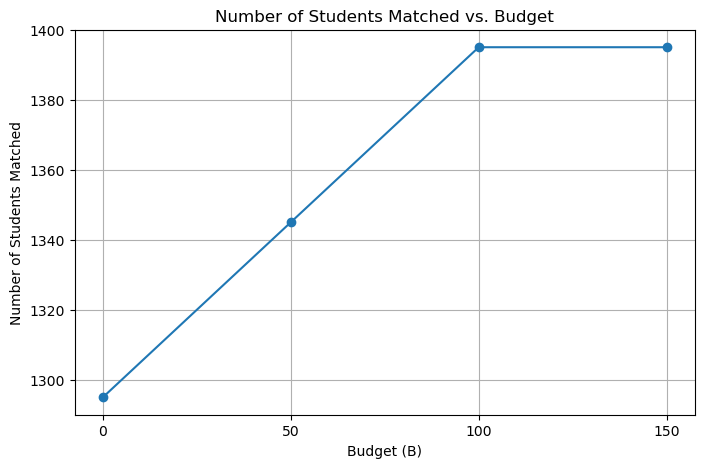

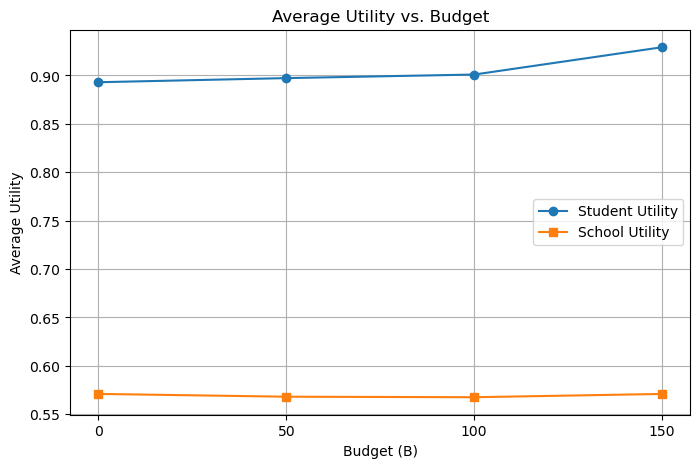

In [7]:
data = {
    "Budget": [0, 50, 100, 150],
    "Total Matched": [1295, 1345, 1395, 1395],
    "Avg Student Utility": [0.893, 0.897262, 0.900944, 0.929172],
    "Avg School Utility": [0.571, 0.568103, 0.567574, 0.570960]
}

budget_df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
plt.plot(budget_df["Budget"], budget_df["Total Matched"], marker='o')
plt.title("Number of Students Matched vs. Budget")
plt.xlabel("Budget (B)")
plt.ylabel("Number of Students Matched")
plt.xticks([0, 50, 100, 150])
plt.grid(True)
plt.show()

# Plot: Avg Student Utility vs. Budget
plt.figure(figsize=(8, 5))
plt.plot(budget_df["Budget"], budget_df["Avg Student Utility"], marker='o', label="Student Utility")
plt.plot(budget_df["Budget"], budget_df["Avg School Utility"], marker='s', label="School Utility")
plt.title("Average Utility vs. Budget")
plt.xlabel("Budget (B)")
plt.ylabel("Average Utility")
plt.xticks([0, 50, 100, 150])
plt.legend()
plt.grid(True)
plt.show()